# Tarea 2
## Diplomado en Tecnologías Cuánticas

In [8]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as plt
import seaborn as sns

from scipy import sparse
from scipy.sparse.linalg import eigsh
from pylanczos import PyLanczos

---
# DMRG

In [9]:

# * Setting basic quantities

## * Spin Operators
sx = sparse.csc_matrix(np.matrix( 
    [[0,1],[1,0]]
))

sy = sparse.csc_matrix(np.matrix(
    [[0,-1j],[1j,0]]
))

sz = sparse.csc_matrix(np.matrix(
    [[1,0],[0,-1]]
))

Spins = [sx,sy,sz] # Vector Matrix, for camputation purposes

## * Idetity Matrix
Id = sparse.csc_matrix(np.identity(2))

## * Dimension threshold
D = 10

## * Number of Iterations
It = 50


## * Model's parameters

def w(shape): # ! Considering a general thermal bath

    # * The parameters of the algorithm quantify the field interaction
    # * strenght as well as the interaction between spins.
    # * In the meantime I'll set them random values between 0 & 1
    
  return np.random.rand(shape)[0]

# TODO: I want to turn this into several classes

def H_seed():

    H_seed = {}
    
    # * Seed System Operators

    H_seed['Id_left'] = Id.copy()
    H_seed['Id_right'] = Id.copy()

    # * No interaction at seed system
    H_seed['H_left'] = Id * 0
    H_seed['H_right'] = Id * 0

    # * Spin Edges
    H_seed['S_left'] = Spins.copy()
    H_seed['S_right'] = Spins.copy()

    return H_seed
    

def H_growth(H_old): # * System merge and diagonalization

    H = H_old.copy()

    ## * Seting variables for readability
    Id_sub_left = H['Id_left']
    Id_sub_right = H['Id_right']

    H_sub_left = H['H_left']
    H_sub_right = H['H_right']

    S_sub_left = H['S_left']
    S_sub_right = H['S_right']

    ## * Spin interactions
    ### * Left sub-system
    Id_left = sp.sparse.kron(Id_sub_left,Id)
    H_left = sp.sparse.kron(H_sub_left, Id)
    H_int_left = [[w(1)*(sp.sparse.kron(i,j)) for i in S_sub_left] for j in Spins] # Spin interactions

    ### * Right sub-system
    Id_right = sp.sparse.kron(Id,Id_sub_right)
    H_right = sp.sparse.kron(Id, H_sub_right)
    H_int_right = [[w(1)*(sp.sparse.kron(i,j)) for i in Spins] for j in S_sub_right] # Spin interactions

    #### * Dropping terms not considered in the model
    for i in (0,1):
        H_int_left[2][i] = H_int_left[2][i]*0
        H_int_left[i][2] = H_int_left[i][2]*0
        H_int_right[i][2] = H_int_right[i][2]*0
        H_int_right[2][i] = H_int_right[2][i]*0

    ### * Computing left & right Interaction Hamiltonians
    H_left += np.sum(H_int_left)
    H_right += np.sum(H_int_right)

    ## * Updating Spin interactions
    S_left = [w(1)*(sp.sparse.kron(Id_sub_left,i)) for i in Spins]
    S_right = [w(1)*(sp.sparse.kron(i,Id_sub_right)) for i in Spins]

    ## * Joining left & right systems
    H_system = sp.sparse.kron(H_left,Id_right) + sp.sparse.kron(Id_left, H_right)

    Sz_system = sp.sparse.kron(S_left[2],S_right[2]) # Sz interaction

    Sxy_system = sum([sp.sparse.kron(i,j) for i,j in zip(S_left[:2],S_right[:2])]) # Sx,Sy interactions for left system

    H_system += Sz_system + Sxy_system

    ## * Exact diagonalization
    e_val,e_vec = eigsh(H_system) # TODO: Measure if Lanczos is faster
    e_vec = sparse.csc_matrix(e_vec)

    ## * Vector state
    psi = e_vec[:,0]

    ### * Updating dict

    H['Id_left'] = Id_left
    H['Id_right'] = Id_right

    H['H_left'] = H_left
    H['H_right'] = H_right

    H['S_left'] = S_left
    H['S_right'] = S_right

    H['H_system'] = H_system

    H['psi'] = psi

    return H


def DMRG(H_old): # * Same procedure for L & R systems
    H = H_old.copy()

    ## * Calling System elements
    Id_sub_left = H['Id_left']
    Id_sub_right = H['Id_right']

    H_sub_left = H['H_left']
    H_sub_right = H['H_right']

    S_sub_left = H['S_left']
    S_sub_right = H['S_right']

    psi = H['psi']

    ## * Density Matrix
    dim_l_sys = np.shape(Id_sub_left)[0]
    dim_r_sys = np.shape(Id_sub_right)[0]
    rho = np.reshape(psi,(dim_l_sys,dim_r_sys))

    ### * Partial Traces of rho
    sigma_left = rho @ rho.conj().T
    sigma_right = rho.T @ rho.conj()

    ## * Rotation Matrix Definition
    def O_matrix(density_matrix):
        auto_val, auto_vec = eigsh(density_matrix.toarray())

        # if np.shape(density_matrix)[0] == 4:
        #     auto_val, auto_vec = eigsh(density_matrix.toarray())
        # else:
        #     auto_val, auto_vec = eigsh(density_matrix)

        threshold = min(D, len(auto_val))
        O = sparse.csc_matrix(auto_vec[-1-threshold:-1,:][::-1,:]) # * Adding highest e-vectors

        return O

    O_left = O_matrix(sigma_left)
    O_right = O_matrix(sigma_right)

    ## * Updating Sub-Systems
    Id_left = O_left @ Id_sub_left @ O_left.conj().T
    Id_right = O_right @Id_sub_right @ O_right.conj().T

    H_left = O_left @ H_sub_left @ O_left.conj().T
    H_right = O_right @ H_sub_right @ O_right.conj().T

    S_left = [O_left @ s @ O_left.conj().T for s in S_sub_left]
    S_right = [O_right @ s @ O_right.conj().T for s in S_sub_right]

    ## * Updating dict
    H['Id_left'] = Id_left
    H['Id_right'] = Id_right

    H['H_left'] = H_left
    H['H_right'] = H_right

    H['S_left'] = S_left
    H['S_right'] = S_right

    return H

In [10]:
def iterations(num):
    H = H_seed()

    for i in range(num):
        H = DMRG(H_growth(H))
        i += 1

    return H

/home/michdata/anaconda3/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1577: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  ret = eigs(A, k, M=M, sigma=sigma, which=which, v0=v0,


<Axes: >

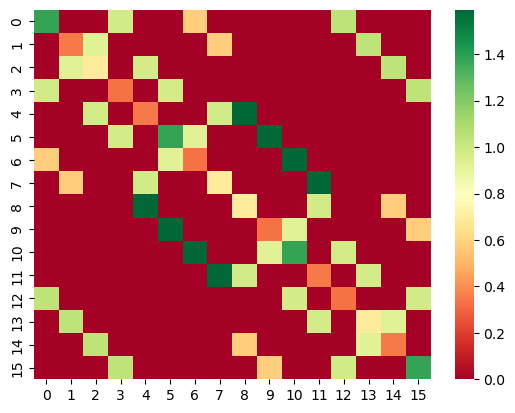

In [11]:
system = iterations(1)['H_system']
sns.heatmap(
    abs(system.toarray()),
    annot = False,
    cmap = 'RdYlGn'
)

/home/michdata/anaconda3/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1577: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  ret = eigs(A, k, M=M, sigma=sigma, which=which, v0=v0,


<Axes: >

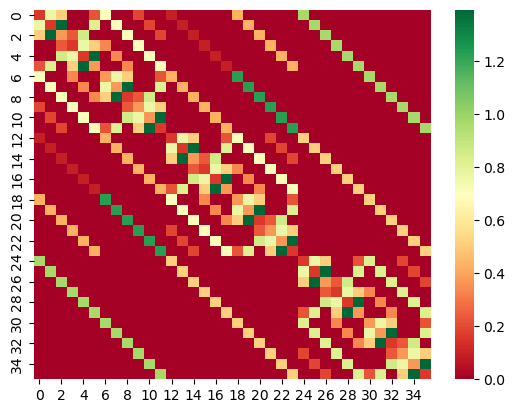

In [12]:
system = iterations(2)['H_system']
sns.heatmap(
    abs(system.toarray()),
    annot = False,
    cmap = 'RdYlGn'
)

In [13]:
import numpy as np

def numerov_solver(V, x0, xf, h):
    # Define the spatial grid
    x = np.arange(x0, xf + h, h)
    
    # Initialize the wavefunction array
    psi = np.zeros_like(x)
    
    # Set the initial conditions
    psi[0] = 0  # Initial value at x0
    psi[1] = 1e-6  # Initial value at x0 - h
    
    # Iterate over the spatial grid
    for i in range(1, len(x) - 1):
        psi[i+1] = (2 * (1 - (5/12) * h**2 * V(x[i])) * psi[i] - (1 + (1/12) * h**2 * V(x[i-1])) * psi[i-1]) / (1 + (1/12) * h**2 * V(x[i+1]))
    
    return x, psi

# Example usage
x0 = 0  # Starting point
xf = 10  # Ending point
h = 0.1  # Step size
om = 1  # Angular frequency
V = lambda x: om*(x**4-2*x**2)  # Potential function

x, psi = numerov_solver(V, x0, xf, h)

In [15]:
display(x)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])